# 🌎 Welcome to the CSE151B Spring 2025 Climate Emulation Competition!

Thank you for participating in this exciting challenge focused on building machine learning models to emulate complex climate systems.  
This notebook is provided as a **starter template** to help you:

- Understand how to load and preprocess the dataset  
- Construct a baseline model  
- Train and evaluate predictions using a PyTorch Lightning pipeline  
- Format your predictions for submission to the leaderboard  

You're encouraged to:
- Build on this structure or replace it entirely
- Try more advanced models and training strategies
- Incorporate your own ideas to push the boundaries of what's possible

If you're interested in developing within a repository structure and/or use helpful tools like configuration management (based on Hydra) and logging (with Weights & Biases), we recommend checking out the following Github repo. Such a structure can be useful when running multiple experiments and trying various research ideas.

👉 [https://github.com/salvaRC/cse151b-spring2025-competition](https://github.com/salvaRC/cse151b-spring2025-competition)

Good luck, have fun, and we hope you learn a lot through this process!


### 📦 Install Required Libraries
We install the necessary Python packages for data loading, deep learning, and visualization.


In [1]:
!pip install xarray zarr dask lightning matplotlib wandb cftime einops --quiet

import os
from datetime import datetime
import numpy as np
import xarray as xr
import dask.array as da
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import lightning.pytorch as pl


### ⚙️ Configuration Setup  
Define all model, data, and training hyperparameters in one place for easy control and reproducibility.

### 📊 Data Configuration

We define the dataset settings used for training and evaluation. This includes:

- **`path`**: Path to the `.zarr` dataset containing monthly climate variables from CMIP6 simulations.
- **`input_vars`**: Climate forcing variables (e.g., CO₂, CH₄) used as model inputs.
- **`output_vars`**: Target variables to predict — surface air temperature (`tas`) and precipitation (`pr`).
- **`target_member_id`**: Ensemble member to use from the simulations (each SSP has 3) for target variables.
- **`train_ssps`**: SSP scenarios used for training (low to high emissions).
- **`test_ssp`**: Scenario held out for evaluation (Must be set to SSP245).
- **`test_months`**: Number of months to include in the test split (Must be set to 120).
- **`batch_size`** and **`num_workers`**: Data loading parameters for PyTorch training.

These settings reflect how the challenge is structured: models must learn from some emission scenarios and generalize to unseen ones.

> ⚠️ **Important:** Do **not modify** the following test settings:
>
> - `test_ssp` must remain **`ssp245`**, which is the held-out evaluation scenario.
> - `test_months` must be **`120`**, corresponding to the last 10 years (monthly resolution) of the scenario.



In [2]:
%pwd

'/home/adapsay/teams/kaggle-group-30/CSE151B_Milestone'

In [3]:
#NOTE Change the data directory according to where you have your zarr files stored
config = {
    "data": {
        "path": "../processed_data_cse151b_v2_corrupted_ssp245/processed_data_cse151b_v2_corrupted_ssp245.zarr",
        # "path": "/kaggle/input/cse151b-spring2025-competition/processed_data_cse151b_v2_corrupted_ssp245/processed_data_cse151b_v2_corrupted_ssp245.zarr",
        "input_vars": ["CO2", "SO2", "CH4", "BC", "rsdt"],
        "output_vars": ["tas", "pr"],
        "target_member_id": 0,
        "train_ssps": ["ssp126", "ssp370", "ssp585"],
        "test_ssp": "ssp245",
        "test_months": 360,
        "batch_size": 64,
        "num_workers": 4,
    },
    "model": {
        "type": "unet_cnn",
        # "kernel_size": 3,
        "init_dim": 64,
        # "depth": 4,
        "dropout_rate": 0.1,
    },
    "training": {
        "lr": 1e-3, 
        "weight_decay": 1e-4,    # ← add this line
    },
    "trainer": {
        "max_epochs": 125,
        "accelerator": "auto",
        "devices": "auto",
        "precision": 32,
        "deterministic": True,
        "num_sanity_val_steps": 0,
    },
    "seed": 42,
}
pl.seed_everything(config["seed"])  # Set seed for reproducibility

Seed set to 42


42

### 📊 Data Configuration

In [4]:
data_path = "../processed_data_cse151b_v2_corrupted_ssp245/processed_data_cse151b_v2_corrupted_ssp245.zarr"

ds = xr.open_zarr(data_path, consolidated=True)
ds

<xarray.Dataset> Size: 621MB
Dimensions:    (ssp: 4, time: 1021, latitude: 48, longitude: 72, x: 72, y: 48,
                member_id: 3)
Coordinates:
    lat        (x, y) float64 28kB dask.array<chunksize=(72, 48), meta=np.ndarray>
  * latitude   (latitude) float64 384B -89.05 -85.26 -81.47 ... 85.26 89.05
    lon        (x, y) float64 28kB dask.array<chunksize=(72, 48), meta=np.ndarray>
  * longitude  (longitude) float64 576B 1.25 6.25 11.25 ... 346.2 351.2 356.2
  * member_id  (member_id) int64 24B 0 1 2
  * ssp        (ssp) <U6 96B 'ssp126' 'ssp245' 'ssp370' 'ssp585'
  * time       (time) object 8kB 2015-01-15 00:00:00 ... 2100-01-15 00:00:00
  * x          (x) float64 576B 1.875 6.875 11.88 16.88 ... 346.9 351.9 356.9
  * y          (y) float64 384B -88.59 -84.82 -81.05 ... 81.05 84.82 88.59
Data variables:
    BC         (ssp, time, latitude, longitude) float64 113MB dask.array<chunksize=(1, 24, 48, 72), meta=np.ndarray>
    CH4        (ssp, time) float64 33kB dask.array<chunksize=(1, 24), meta=np.ndarray>
    CO2        (ssp, time) float64 33kB dask.array<chunksize=(1, 24), meta=np.ndarray>
    SO2        (ssp, time, latitude, longitude) float64 113MB dask.array<chunksize=(1, 24, 48, 72), meta=np.ndarray>
    pr         (ssp, time, member_id, y, x) float32 169MB dask.array<chunksize=(1, 24, 1, 48, 72), meta=np.ndarray>
    rsdt       (ssp, time, y, x) float32 56MB dask.array<chunksize=(1, 24, 48, 72), meta=np.ndarray>
    tas        (ssp, time, member_id, y, x) float32 169MB dask.array<chunksize=(1, 24, 1, 48, 72), meta=np.ndarray>
Attributes:
    original_member_ids:  ['r10i1p1f1', 'r11i1p1f1', 'r4i1p1f1']
    precipitation_units:  mm/day (converted from kg m-2 s-1)
    source:               CMIP6 data processed for CSE151B
    ssp:                  ssp126

### Data Exploration

**Spatial Dimensions, Size of Train/Validate/Test Data**

We know there are 1021 time steps per SSP (1021 months).

In [5]:
ssp_train = ['ssp126', 'ssp585']
ssp_val = 'ssp370'
ssp_test = 'ssp245'

n_members = ds.sizes['member_id']
n_time_total = ds.sizes['time']
# print(n_time_total)
lat = ds.sizes['latitude']
lon = ds.sizes['longitude']

# TRAINING = full ssp126 + ssp585 + first 901 months of ssp370
# (since last 10 years / 120 months of SSP370 is the validation set)
n_train_ssp126 = n_time_total * n_members
n_train_ssp585 = n_time_total * n_members
n_train_ssp370 = (n_time_total - 120) * n_members  # time 0 to 900 inclusive
n_train_samples = n_train_ssp126 + n_train_ssp585 + n_train_ssp370

# VALIDATION = last 120 months of ssp370, member_id = 0
n_val_samples = 120

# TEST = last 360 months of ssp245, member_id = 0
n_test_samples = 360

print(f"Spatial Dimensions per sample: (lat, lon) =, {(lat, lon)} --> 3456 grid points")
print("Training samples:", n_train_samples)
print("Validation samples:", n_val_samples)
print("Test samples:", n_test_samples)
n_train_samples + n_val_samples + n_test_samples

Spatial Dimensions per sample: (lat, lon) =, (48, 72) --> 3456 grid points
Training samples: 8829
Validation samples: 120
Test samples: 360


9309

In [6]:
lat_dim = ds.sizes["latitude"]
lon_dim = ds.sizes["longitude"]
n_spatial = lat_dim * lon_dim
print(f"Spatial dimensions: {lat_dim} x {lon_dim} = {n_spatial} grid points")

Spatial dimensions: 48 x 72 = 3456 grid points


**1b)** The dataset consists of 8,829 training samples drawn from ssp126, ssp370 (first 901 months), and ssp585 across all 3 ensemble members. Validation includes 120 samples from the last 10 years (120 months) of ssp370 using only member_id = 0. The test set contains 360 samples from the last 360 months of ssp245, also using only member_id = 0. We only use member_id = 0 because the competition evaluation is performed on a single ensemble realization (member_id = 0), and using multiple ensemble members for validation or testing would misrepresent model performance (data leakage from internal climate variability across ensemble runs).

There are 2 spatial dimensions (latitude and longitude) forming a 48 × 72 global grid. Each sample covers the full grid, so each sample contains 3,456 spatial points.

**Distribution of Target Variables, Input Data**

In [7]:
ds["tas"]
ds["tas"].sel(ssp="ssp245", member_id=0)


<xarray.DataArray 'tas' (time: 1021, y: 48, x: 72)> Size: 14MB
dask.array<getitem, shape=(1021, 48, 72), dtype=float32, chunksize=(24, 48, 72), chunktype=numpy.ndarray>
Coordinates:
    lat        (x, y) float64 28kB dask.array<chunksize=(72, 48), meta=np.ndarray>
    lon        (x, y) float64 28kB dask.array<chunksize=(72, 48), meta=np.ndarray>
    member_id  int64 8B 0
    ssp        <U6 24B 'ssp245'
  * time       (time) object 8kB 2015-01-15 00:00:00 ... 2100-01-15 00:00:00
  * x          (x) float64 576B 1.875 6.875 11.88 16.88 ... 346.9 351.9 356.9
  * y          (y) float64 384B -88.59 -84.82 -81.05 ... 81.05 84.82 88.59
Attributes: (12/19)
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        TREFHT
    description:    near-surface (usually, 2 meter) air temperature
    frequency:      day
    id:             tas
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Near-Surface Air Temperature
    type:           real
    units:          K
    variable_id:    tas

In [8]:
ds["tas"].sel(ssp="ssp245", member_id=0).isel(time=0)


<xarray.DataArray 'tas' (y: 48, x: 72)> Size: 14kB
dask.array<getitem, shape=(48, 72), dtype=float32, chunksize=(48, 72), chunktype=numpy.ndarray>
Coordinates:
    lat        (x, y) float64 28kB dask.array<chunksize=(72, 48), meta=np.ndarray>
    lon        (x, y) float64 28kB dask.array<chunksize=(72, 48), meta=np.ndarray>
    member_id  int64 8B 0
    ssp        <U6 24B 'ssp245'
    time       object 8B 2015-01-15 00:00:00
  * x          (x) float64 576B 1.875 6.875 11.88 16.88 ... 346.9 351.9 356.9
  * y          (y) float64 384B -88.59 -84.82 -81.05 ... 81.05 84.82 88.59
Attributes: (12/19)
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        TREFHT
    description:    near-surface (usually, 2 meter) air temperature
    frequency:      day
    id:             tas
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Near-Surface Air Temperature
    type:           real
    units:          K
    variable_id:    tas

In [9]:
ssp_train = ["ssp126", "ssp370", "ssp585"]
input_vars = ["CO2", "CH4", "SO2", "BC", "rsdt"]
output_vars = ["tas", "pr"]

def clean_flat(arr):
    return arr.compute().values.flatten()[~np.isnan(arr.compute().values.flatten())]

def print_stats(values):
    zero_count = (values == 0).sum()
    print(
        f"count = {len(values):>6} | "
        f"mean = {np.mean(values)} | "
        f"std = {np.std(values)} | "
        f"median = {np.median(values)} | "
        f"min = {np.min(values)} | "
        f"max = {np.max(values)} | "
        f"5th–95th pct = {np.percentile(values, 5)} – {np.percentile(values, 95)} | "
        f"zeros = {zero_count} ({100 * zero_count / len(values)}%)"
    )

# input data
for var in input_vars:
    print(f"\n--------- INPUT VARIABLE: {var} ---------")
    for ssp in ssp_train:
        print(f"SSP: {ssp}")
        arr = ds[var].sel(ssp=ssp)
        if "member_id" in arr.dims:
            arr = arr.sel(member_id=0)
        values = clean_flat(arr)
        
        print_stats(values)

        plt.hist(values, bins=100)
        plt.title(f"{var} Distribution – {ssp}")
        plt.xlabel(var)
        plt.ylabel("Frequency")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"figures/{var}_{ssp}_dist.png", dpi=300)
        plt.close()
        # plt.show()

# target vars
for var in output_vars:
    print(f"\n--------- TARGET VARIABLE: {var} ---------")
    for ssp in ssp_train:
        print(f"SSP: {ssp}")
        arr = ds[var].sel(ssp=ssp, member_id=0)
        values = clean_flat(arr)

        print_stats(values)

        plt.hist(values, bins=100)
        plt.title(f"{var} Distribution – {ssp}")
        plt.xlabel(var)
        plt.ylabel("Frequency")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"figures/{var}_{ssp}_dist.png", dpi=300)
        plt.close()
        # plt.show()


--------- INPUT VARIABLE: CO2 ---------
SSP: ssp126
count =   1021 | mean = 2532.318713977056 | std = 401.69992064797714 | median = 2731.6626772312566 | min = 1536.0722224547292 | max = 2891.7034108052826 | 5th–95th pct = 1689.6271652350188 – 2889.948210871908 | zeros = 0 (0.0%)
SSP: ssp370
count =   1021 | mean = 3874.4328704822187 | std = 1528.9858993886194 | median = 3751.897249353455 | min = 1536.0722224547292 | max = 6763.858968521363 | 5th–95th pct = 1699.3051121573612 – 6426.770585143383 | zeros = 0 (0.0%)
SSP: ssp585
count =   1021 | mean = 4653.006907184912 | std = 2343.882160473454 | median = 4182.662019889618 | min = 1536.0722224547292 | max = 9362.59353129993 | 5th–95th pct = 1696.662145353775 – 8816.81862612959 | zeros = 0 (0.0%)

--------- INPUT VARIABLE: CH4 ---------
SSP: ssp126
count =   1021 | mean = 0.1990533398174867 | std = 0.07149415080379436 | median = 0.18533224375025475 | min = 0.11364517919757215 | max = 0.37373672410518455 | 5th–95th pct = 0.1164790331243431

In [10]:
def plot_distribution_across_ssps(ds, var, time_idx, ssp_list=["ssp126", "ssp370", "ssp585"], member_id=0, bins=100):
    os.makedirs("figures", exist_ok=True)
    plt.figure(figsize=(8, 8))

    for ssp in ssp_list:
        arr = ds[var].sel(ssp=ssp, member_id=member_id).isel(time=time_idx)
        values = arr.compute().values.flatten()
        values = values[~np.isnan(values)]

        plt.hist(values, bins=bins, alpha=0.3, label=ssp)

    try:
        time_str = str(ds["time"].isel(time=time_idx).values)[:10].replace("-", "")
    except:
        time_str = f"t{time_idx}"

    plt.title(f"Distribution of {var} at {time_str} Across SSPs")
    plt.xlabel(f"{var} value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Save instead of showing
    filename = f"figures/{var}_ssp_comparison_{time_str}.png"
    plt.savefig(filename, dpi=300)
    plt.close()
    print(f"Saved: {filename}")
    # plt.show()


In [11]:
plot_distribution_across_ssps(ds, var="tas", time_idx=0)
plot_distribution_across_ssps(ds, var="pr", time_idx=0)
plot_distribution_across_ssps(ds, var="tas", time_idx=1020)
plot_distribution_across_ssps(ds, var="pr", time_idx=1020)

Saved: figures/tas_ssp_comparison_20150115.png
Saved: figures/pr_ssp_comparison_20150115.png
Saved: figures/tas_ssp_comparison_21000115.png
Saved: figures/pr_ssp_comparison_21000115.png


In [10]:
def plot_distribution_over_time(ds, ssp, var, time_indices, member_id=0, bins=100):
    os.makedirs("figures", exist_ok=True)
    plt.figure(figsize=(8, 5))

    label_parts = []

    for time_idx in time_indices:
        arr = ds[var].sel(ssp=ssp, member_id=member_id).isel(time=time_idx)
        values = arr.compute().values.flatten()
        values = values[~np.isnan(values)]

        try:
            time_label = str(ds["time"].isel(time=time_idx).values)[:10]
            label_parts.append(time_label.replace("-", ""))
        except:
            time_label = f"t{time_idx}"
            label_parts.append(time_label)

        plt.hist(values, bins=bins, alpha=0.5, label=time_label)

    label_str = "_".join(label_parts)
    plt.title(f"{var.upper()} Distribution Over Time – {ssp}")
    plt.xlabel(f"{var} value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    filename = f"figures/{var}_{ssp}_overtime_{label_str}.png"
    plt.savefig(filename, dpi=300)
    plt.close()
    print(f"Saved: {filename}")
    # plt.show()


In [11]:
plot_distribution_over_time(ds, "ssp126", "tas", [0, 1020])
plot_distribution_over_time(ds, "ssp126", "pr", [0, 1020])
plot_distribution_over_time(ds, "ssp585", "tas", [0, 1020])
plot_distribution_over_time(ds, "ssp585", "pr", [0, 1020])

Saved: figures/tas_ssp126_overtime_20150115_21000115.png
Saved: figures/pr_ssp126_overtime_20150115_21000115.png
Saved: figures/tas_ssp585_overtime_20150115_21000115.png
Saved: figures/pr_ssp585_overtime_20150115_21000115.png


### 🔧 Spatial Weighting Utility Function

This cell sets up utility functions for reproducibility and spatial weighting:

- **`get_lat_weights(latitude_values)`**: Computes cosine-based area weights for each latitude, accounting for the Earth's curvature. This is critical for evaluating global climate metrics fairly — grid cells near the equator represent larger surface areas than those near the poles.


In [33]:
def get_lat_weights(latitude_values):
    lat_rad = np.deg2rad(latitude_values)
    weights = np.cos(lat_rad)
    return weights / np.mean(weights)

### 🧠 SimpleCNN: A Residual Convolutional Baseline

This is a lightweight baseline model designed to capture spatial patterns in global climate data using convolutional layers.

- The architecture starts with a **convolution + batch norm + ReLU** block to process the input channels.
- It then applies a series of **residual blocks** to extract increasingly abstract spatial features. These help preserve gradient flow during training.
- Finally, a few convolutional layers reduce the feature maps down to the desired number of output channels (`tas` and `pr`).

This model only serves as a **simple baseline for climate emulation**. 

We encourage you to build and experiment with your own models and ideas.


In [34]:
import torch
import torch.nn as nn

class CoordConv(nn.Module):
    def forward(self, x):
        B, C, H, W = x.shape
        yy = torch.linspace(-1, 1, H, device=x.device).view(1,1,H,1).expand(B,1,H,W)
        xx = torch.linspace(-1, 1, W, device=x.device).view(1,1,1,W).expand(B,1,H,W)
        return torch.cat([x, xx, yy], dim=1)

class UNetBlock(nn.Module):
    def __init__(self, in_ch, out_ch, k=3):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, k, padding=k//2),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, k, padding=k//2),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.block(x)

class UNetCNN(nn.Module):
    def __init__(self, n_input_channels, n_output_channels, init_dim=64, dropout_rate=0.2):
        super().__init__()
        # Coord embedding + first encoder
        self.coord  = CoordConv()
        self.enc1   = UNetBlock(n_input_channels + 2, init_dim)
        self.pool1  = nn.MaxPool2d(2)
        # Second encoder
        self.enc2   = UNetBlock(init_dim, init_dim*2)
        self.pool2  = nn.MaxPool2d(2)
        # Bottleneck
        self.bottleneck = UNetBlock(init_dim*2, init_dim*4)
        # Decoder
        self.up2    = nn.ConvTranspose2d(init_dim*4, init_dim*2, 2, stride=2)
        self.dec2   = UNetBlock(init_dim*4, init_dim*2)
        self.up1    = nn.ConvTranspose2d(init_dim*2, init_dim,   2, stride=2)
        self.dec1   = UNetBlock(init_dim*2, init_dim)
        # Dropout + final projection
        self.dropout = nn.Dropout2d(dropout_rate)
        self.final   = nn.Conv2d(init_dim, n_output_channels, kernel_size=1)

    def forward(self, x):
        x  = self.coord(x)         # add coordinate channels
        e1 = self.enc1(x)          # [B, init_dim, 48,72]
        e2 = self.enc2(self.pool1(e1))
        b  = self.bottleneck(self.pool2(e2))
        d2 = self.dec2(torch.cat([self.up2(b), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        out = self.dropout(d1)
        return self.final(out)     # [B, n_output_channels, 48,72]


### 📐 Normalizer: Z-Score Scaling for Climate Inputs & Outputs

This class handles **Z-score normalization**, a crucial preprocessing step for stable and efficient neural network training:

- **`set_input_statistics(mean, std)` / `set_output_statistics(...)`**: Store the mean and standard deviation computed from the training data for later use.
- **`normalize(data, data_type)`**: Standardizes the data using `(x - mean) / std`. This is applied separately to inputs and outputs.
- **`inverse_transform_output(data)`**: Converts model predictions back to the original physical units (e.g., Kelvin for temperature, mm/day for precipitation).

Normalizing the data ensures the model sees inputs with similar dynamic ranges and avoids biases caused by different variable scales.


In [35]:
# class Normalizer:
#     def __init__(self):
#         self.mean_in, self.std_in = None, None
#         self.mean_out, self.std_out = None, None

#     def set_input_statistics(self, mean, std):
#         self.mean_in = mean
#         self.std_in = std

#     def set_output_statistics(self, mean, std):
#         self.mean_out = mean
#         self.std_out = std

#     def normalize(self, data, data_type):
#         if data_type == "input":
#             return (data - self.mean_in) / self.std_in
#         elif data_type == "output":
#             return (data - self.mean_out) / self.std_out

#     def inverse_transform_output(self, data):
#         return data * self.std_out + self.mean_out


In [36]:
class ChannelwiseNormalizer:
    def __init__(self):
        self.mean_in, self.std_in = None, None
        self.mean_tas, self.std_tas = None, None

    def set_input_statistics(self, mean, std):
        self.mean_in = mean
        self.std_in = std

    def set_output_statistics(self, mean, std):
        self.mean_tas = mean[:, 0:1]
        self.std_tas  = std[:, 0:1]

    def normalize(self, data, data_type):
        if data_type == "input":
            return (data - self.mean_in) / self.std_in
        elif data_type == "output":
            tas = (data[:, 0:1] - self.mean_tas) / self.std_tas
            pr  = data[:, 1:2]  # <- already log-transformed!
            return da.concatenate([tas, pr], axis=1)
            
    def inverse_transform_output(self, data):
        # assumes `data` is a numpy array
        tas = data[:, 0:1] * self.std_tas + self.mean_tas
        pr  = np.expm1(data[:, 1:2])  # <- ✅ use NumPy version
        return np.concatenate([tas, pr], axis=1)


### 🌍 Data Module: Loading, Normalization, and Splitting

This section handles the entire data pipeline, from loading the `.zarr` dataset to preparing PyTorch-ready DataLoaders.

#### `ClimateDataset`
- A simple PyTorch `Dataset` wrapper that preloads the entire (normalized) dataset into memory using Dask.
- Converts the data to PyTorch tensors and handles any `NaN` checks up front.

#### `ClimateDataModule`
A PyTorch Lightning `DataModule` that handles:
- ✅ **Loading data** from different SSP scenarios and ensemble members
- ✅ **Broadcasting non-spatial inputs** (like CO₂) to match spatial grid size
- ✅ **Normalization** using mean/std computed from training data only
- ✅ **Splitting** into training, validation, and test sets:
  - Training: All months from selected SSPs (except last 10 years of SSP370)
  - Validation: Last 10 years (120 months) of SSP370
  - Test: Last 10 years of SSP245 (unseen scenario)
- ✅ **Batching** and parallelized data loading via PyTorch `DataLoader`s
- ✅ **Latitude-based area weighting** for fair climate metric evaluation
- Shape of the inputs are Batch_Size X 5 (num_input_variables) X 48 X 72
- Shape of ouputputs are Batch_Size X 2 (num_output_variables) X 48 X 72

> ℹ️ **Note:** You likely won’t need to modify this class but feel free to make modifications if you want to inlcude different ensemble mebers to feed more data to your models


In [37]:
class ClimateDataset(Dataset):
    def __init__(self, inputs_dask, outputs_dask, output_is_normalized=True):
        self.size = inputs_dask.shape[0]
        print(f"Creating dataset with {self.size} samples...")

        inputs_np = inputs_dask.compute()
        outputs_np = outputs_dask.compute()

        self.inputs = torch.from_numpy(inputs_np).float()
        self.outputs = torch.from_numpy(outputs_np).float()

        if torch.isnan(self.inputs).any() or torch.isnan(self.outputs).any():
            raise ValueError("NaNs found in dataset")

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]


class ClimateDataModule(pl.LightningDataModule):
    def __init__(
        self,
        path,
        input_vars,
        output_vars,
        train_ssps,
        test_ssp,
        target_member_id,
        val_split=0.1,
        test_months=360,
        batch_size=32,
        num_workers=0,
        seed=42,
    ):
        super().__init__()
        self.path = path
        self.input_vars = input_vars
        self.output_vars = output_vars
        self.train_ssps = train_ssps
        self.test_ssp = test_ssp
        self.target_member_id = target_member_id
        self.val_split = val_split
        self.test_months = test_months
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.seed = seed
        # self.normalizer = Normalizer()
        self.normalizer = ChannelwiseNormalizer()


    def prepare_data(self):
        assert os.path.exists(self.path), f"Data path not found: {self.path}"

    def setup(self, stage=None):
        ds = xr.open_zarr(self.path, consolidated=False, chunks={"time": 24})
        spatial_template = ds["rsdt"].isel(time=0, ssp=0, drop=True)

        def log_transform_pr(output_dask):
            # Assumes output_dask shape is [time, channels=2, y, x]
            pr = output_dask[:, 1:2, :, :]  # select only pr channel
            log_pr = da.log1p(pr)
            return da.concatenate([output_dask[:, 0:1], log_pr], axis=1)

        def load_ssp(ssp):
            input_dask, output_dask = [], []
            for var in self.input_vars:
                da_var = ds[var].sel(ssp=ssp)
                if "latitude" in da_var.dims:
                    da_var = da_var.rename({"latitude": "y", "longitude": "x"})
                if "member_id" in da_var.dims:
                    da_var = da_var.sel(member_id=self.target_member_id)
                if set(da_var.dims) == {"time"}:
                    da_var = da_var.broadcast_like(spatial_template).transpose("time", "y", "x")
                input_dask.append(da_var.data)

            for var in self.output_vars:
                da_out = ds[var].sel(ssp=ssp, member_id=self.target_member_id)
                if "latitude" in da_out.dims:
                    da_out = da_out.rename({"latitude": "y", "longitude": "x"})
                output_dask.append(da_out.data)

            return da.stack(input_dask, axis=1), da.stack(output_dask, axis=1)

        train_input, train_output, val_input, val_output = [], [], None, None

        for ssp in self.train_ssps:
            x, y = load_ssp(ssp)
            if ssp == "ssp370":
                val_input = x[-self.test_months:]
                val_output = y[-self.test_months:]
                train_input.append(x[:-self.test_months])
                train_output.append(y[:-self.test_months])
            else:
                train_input.append(x)
                train_output.append(y)

        train_input = da.concatenate(train_input, axis=0)
        train_output = da.concatenate(train_output, axis=0)
        
        # ✅ Load and transform test SSP BEFORE normalization
        test_input, test_output = load_ssp(self.test_ssp)
        test_input = test_input[-self.test_months:]
        test_output = test_output[-self.test_months:]
        
        # ✅ Apply log transform to pr for all outputs
        train_output = log_transform_pr(train_output)
        val_output   = log_transform_pr(val_output)
        test_output  = log_transform_pr(test_output)


        self.normalizer.set_input_statistics(
            mean=da.nanmean(train_input, axis=(0, 2, 3), keepdims=True).compute(),
            std=da.nanstd(train_input, axis=(0, 2, 3), keepdims=True).compute(),
        )

        self.normalizer.set_output_statistics(
            mean=da.nanmean(train_output, axis=(0, 2, 3), keepdims=True).compute(),
            std=da.nanstd(train_output, axis=(0, 2, 3), keepdims=True).compute(),
        )

        train_input_norm = self.normalizer.normalize(train_input, "input")
        train_output_norm = self.normalizer.normalize(train_output, "output")
        val_input_norm = self.normalizer.normalize(val_input, "input")
        val_output_norm = self.normalizer.normalize(val_output, "output")

        test_input_norm = self.normalizer.normalize(test_input, "input")

        self.train_dataset = ClimateDataset(train_input_norm, train_output_norm)
        self.val_dataset = ClimateDataset(val_input_norm, val_output_norm)
        # self.test_dataset = ClimateDataset(test_input_norm, test_output, output_is_normalized=False)
        test_output_norm = self.normalizer.normalize(test_output, "output")
        self.test_dataset = ClimateDataset(test_input_norm, test_output_norm)


        self.lat = spatial_template.y.values
        self.lon = spatial_template.x.values
        self.area_weights = xr.DataArray(get_lat_weights(self.lat), dims=["y"], coords={"y": self.lat})

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True,
                          num_workers=self.num_workers, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False,
                          num_workers=self.num_workers, pin_memory=True)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False,
                          num_workers=self.num_workers, pin_memory=True)

    def get_lat_weights(self):
        return self.area_weights

    def get_coords(self):
        return self.lat, self.lon

### ⚡ ClimateEmulationModule: Lightning Wrapper for Climate Model Emulation

This is the core model wrapper built with **PyTorch Lightning**, which organizes the training, validation, and testing logic for the climate emulation task. Lightning abstracts away much of the boilerplate code in PyTorch-based deep learning workflows, making it easier to scale models.

#### ✅ Key Features

- **`training_step` / `validation_step` / `test_step`**: Standard Lightning hooks for computing loss and predictions at each stage. The loss used is **Mean Squared Error (MSE)**.

- **Normalization-aware outputs**:
  - During validation and testing, predictions and targets are denormalized before evaluation using stored mean/std statistics.
  - This ensures evaluation is done in real-world units (Kelvin and mm/day).

- **Metric Evaluation** via `_evaluate()`:
  For each variable (`tas`, `pr`), it calculates:
  - **Monthly Area-Weighted RMSE**
  - **Time-Mean RMSE** (RMSE on 10-year average's)
  - **Time-Stddev MAE** (MAE on 10-year standard deviation; a measure of temporal variability)
    
  These metrics reflect the competition's evaluation criteria and are logged and printed.

- **Kaggle Submission Writer**:
  After testing, predictions are saved to a `.csv` file in the required Kaggle format via `_save_submission()`.

- **Saving Predictions for Visualization**:
  - Validation predictions are saved tao `val_preds.npy` and `val_trues.npy`
  - These can be loaded later for visual inspection of the model's performance.

 🔧 **Feel free to modify any part of this module** (loss functions, evaluation, training logic) to better suit your model or training pipeline / Use pure PyTorch etc.

⚠️ The **final submission `.csv` file must strictly follow the format and naming convention used in `_save_submission()`**, as these `ID`s are used to match predictions to the hidden test set during evaluation.



In [38]:
import pandas as pd

class ClimateEmulationModule(pl.LightningModule):
    def __init__(self, model, learning_rate=1e-4, weight_decay=0.0):
        super().__init__()
        self.model = model
        # Save both lr & weight_decay into self.hparams
        self.save_hyperparameters("learning_rate", "weight_decay", ignore=["model"])
        # self.criterion = nn.MSELoss()
        self.criterion_tas = nn.MSELoss()
        self.criterion_pr  = nn.MSELoss()
        self.normalizer = None
        self.val_preds, self.val_targets = [], []
        self.test_preds, self.test_targets = [], []

    def forward(self, x):
        return self.model(x)

    def on_fit_start(self):
        self.normalizer = self.trainer.datamodule.normalizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        # loss = self.criterion(y_hat, y)
        tas_hat, pr_hat = y_hat[:, 0:1], y_hat[:, 1:2]
        tas_true, pr_true = y[:, 0:1], y[:, 1:2]
        loss_tas = self.criterion_tas(tas_hat, tas_true)
        loss_pr  = self.criterion_pr(pr_hat, pr_true)
        loss = loss_tas + loss_pr
        self.log("train/loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        # loss = self.criterion(y_hat, y)
        tas_hat, pr_hat = y_hat[:, 0:1], y_hat[:, 1:2]
        tas_true, pr_true = y[:, 0:1], y[:, 1:2]
        loss_tas = self.criterion_tas(tas_hat, tas_true)
        loss_pr  = self.criterion_pr(pr_hat, pr_true)
        loss = loss_tas + loss_pr
        self.log("val/loss", loss)

        y_hat_np = self.normalizer.inverse_transform_output(y_hat.detach().cpu().numpy())
        y_np     = self.normalizer.inverse_transform_output(y.detach().cpu().numpy())
        self.val_preds.append(y_hat_np)
        self.val_targets.append(y_np)
        return loss

    def on_validation_epoch_end(self):
        preds = np.concatenate(self.val_preds, axis=0)
        trues = np.concatenate(self.val_targets, axis=0)
        self._evaluate(preds, trues, phase="val")
        np.save("val_preds.npy", preds)
        np.save("val_trues.npy", trues)
        self.val_preds.clear()
        self.val_targets.clear()

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat_np = self.normalizer.inverse_transform_output(y_hat.detach().cpu().numpy())
        y_np     = y.detach().cpu().numpy()
        self.test_preds.append(y_hat_np)
        self.test_targets.append(y_np)

    def on_test_epoch_end(self):
        preds = np.concatenate(self.test_preds, axis=0)
        trues = np.concatenate(self.test_targets, axis=0)
        self._evaluate(preds, trues, phase="test")
        self._save_submission(preds)
        self.test_preds.clear()
        self.test_targets.clear()

    def configure_optimizers(self):
        optimizer = optim.Adam(
            self.parameters(),
            lr=self.hparams.learning_rate,
            weight_decay=self.hparams.weight_decay,
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=self.trainer.max_epochs,
            eta_min=self.hparams.learning_rate * 0.01,
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch",
                "monitor": "val/tas/rmse",
            }
        }

    def _evaluate(self, preds, trues, phase="val"):
        datamodule = self.trainer.datamodule
        area_weights = datamodule.get_lat_weights()
        lat, lon = datamodule.get_coords()
        time = np.arange(preds.shape[0])
        output_vars = datamodule.output_vars

        for i, var in enumerate(output_vars):
            p = preds[:, i]
            t = trues[:, i]
            p_xr = xr.DataArray(p, dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})
            t_xr = xr.DataArray(t, dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})

            # RMSE
            rmse = np.sqrt(((p_xr - t_xr) ** 2).weighted(area_weights).mean(("time", "y", "x")).item())
            # RMSE of time-mean
            mean_rmse = np.sqrt(((p_xr.mean("time") - t_xr.mean("time")) ** 2).weighted(area_weights).mean(("y", "x")).item())
            # MAE of time-stddev
            std_mae = np.abs(p_xr.std("time") - t_xr.std("time")).weighted(area_weights).mean(("y", "x")).item()

            print(f"[{phase.upper()}] {var}: RMSE={rmse:.4f}, Time-Mean RMSE={mean_rmse:.4f}, Time-Stddev MAE={std_mae:.4f}")
            self.log_dict({
                f"{phase}/{var}/rmse": rmse,
                f"{phase}/{var}/time_mean_rmse": mean_rmse,
                f"{phase}/{var}/time_std_mae": std_mae,
            })

    def _save_submission(self, predictions):
        datamodule = self.trainer.datamodule
        lat, lon = datamodule.get_coords()
        output_vars = datamodule.output_vars
        time = np.arange(predictions.shape[0])

        rows = []
        for t_idx, t in enumerate(time):
            for var_idx, var in enumerate(output_vars):
                for y_idx, y in enumerate(lat):
                    for x_idx, x in enumerate(lon):
                        row_id = f"t{t_idx:03d}_{var}_{y:.2f}_{x:.2f}"
                        pred = predictions[t_idx, var_idx, y_idx, x_idx]
                        rows.append({"ID": row_id, "Prediction": pred})

        df = pd.DataFrame(rows)
        os.makedirs("submissions", exist_ok=True)
        filepath = f"submissions/kaggle_submission_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
        df.to_csv(filepath, index=False)
        print(f"✅ Submission saved to: {filepath}")

### ⚡ Training & Evaluation with PyTorch Lightning

This block sets up and runs the training and testing pipeline using **PyTorch Lightning’s `Trainer`**, which abstracts away much of the boilerplate in deep learning workflows.

- **Modular Setup**:
  - `datamodule`: Handles loading, normalization, and batching of climate data.
  - `model`: A convolutional neural network that maps climate forcings to predicted outputs.
  - `lightning_module`: Wraps the model with training/validation/test logic and metric evaluation.

- **Trainer Flexibility**:
  The `Trainer` accepts a wide range of configuration options from `config["trainer"]`, including:
  - Number of epochs
  - Precision (e.g., 16-bit or 32-bit)
  - Device configuration (CPU, GPU, or TPU)
  - Determinism, logging, callbacks, and more

In [39]:
datamodule = ClimateDataModule(**config["data"])

model = UNetCNN(
    n_input_channels=len(config["data"]["input_vars"]),
    n_output_channels= len(config["data"]["output_vars"]),
    init_dim=config["model"]["init_dim"],
    dropout_rate=config["model"]["dropout_rate"]
)

lightning_module = ClimateEmulationModule(
    model,
    learning_rate=config["training"]["lr"],
    weight_decay=config["training"]["weight_decay"],
)


In [40]:
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
early_stop = EarlyStopping(
    monitor="val/tas/rmse",
    patience=20,
    mode="min"
)
checkpoint = ModelCheckpoint(
    monitor="val/tas/rmse",
    mode="min",
    save_top_k=1,
    filename="unet-best-{epoch:02d}-{val/tas/rmse:.4f}"
)

# Updated Trainer with callbacks
trainer = pl.Trainer(
    **config["trainer"],
    callbacks=[early_stop, checkpoint]
)

trainer.fit(lightning_module, datamodule=datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Creating dataset with 2703 samples...
Creating dataset with 360 samples...
Creating dataset with 360 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type    | Params | Mode 
--------------------------------------------------
0 | model         | UNetCNN | 1.9 M  | train
1 | criterion_tas | MSELoss | 0      | train
2 | criterion_pr  | MSELoss | 0      | train
--------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.471     Total estimated model params size (MB)
50        Modules in train mode
0         Modules in eval mode
/home/adapsay/.local/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=6.1083, Time-Mean RMSE=4.9927, Time-Stddev MAE=1.3548
[VAL] pr: RMSE=3.1358, Time-Mean RMSE=1.5843, Time-Stddev MAE=1.7763


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.2493, Time-Mean RMSE=3.9653, Time-Stddev MAE=0.9922
[VAL] pr: RMSE=3.1033, Time-Mean RMSE=1.6274, Time-Stddev MAE=1.7029


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.5478, Time-Mean RMSE=3.0406, Time-Stddev MAE=1.0704
[VAL] pr: RMSE=2.8834, Time-Mean RMSE=1.2563, Time-Stddev MAE=1.6093


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=3.7435, Time-Mean RMSE=1.8731, Time-Stddev MAE=0.9408
[VAL] pr: RMSE=2.9268, Time-Mean RMSE=1.3710, Time-Stddev MAE=1.6226


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=3.5502, Time-Mean RMSE=1.6425, Time-Stddev MAE=1.1764
[VAL] pr: RMSE=2.8790, Time-Mean RMSE=1.2808, Time-Stddev MAE=1.5708


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=3.4608, Time-Mean RMSE=1.5533, Time-Stddev MAE=0.9219
[VAL] pr: RMSE=2.7885, Time-Mean RMSE=1.1228, Time-Stddev MAE=1.5068


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=3.6181, Time-Mean RMSE=2.0974, Time-Stddev MAE=1.4061
[VAL] pr: RMSE=2.8361, Time-Mean RMSE=1.2181, Time-Stddev MAE=1.5722


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=3.0224, Time-Mean RMSE=1.3324, Time-Stddev MAE=0.8722
[VAL] pr: RMSE=2.6860, Time-Mean RMSE=1.1100, Time-Stddev MAE=1.3924


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=3.0186, Time-Mean RMSE=1.4709, Time-Stddev MAE=0.6375
[VAL] pr: RMSE=2.4706, Time-Mean RMSE=0.8273, Time-Stddev MAE=1.2379


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.7652, Time-Mean RMSE=1.3790, Time-Stddev MAE=0.7960
[VAL] pr: RMSE=2.5489, Time-Mean RMSE=1.1404, Time-Stddev MAE=1.1822


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.3096, Time-Mean RMSE=1.0275, Time-Stddev MAE=0.6224
[VAL] pr: RMSE=2.3216, Time-Mean RMSE=0.8379, Time-Stddev MAE=1.1341


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.4262, Time-Mean RMSE=1.3040, Time-Stddev MAE=0.7500
[VAL] pr: RMSE=2.2590, Time-Mean RMSE=0.7493, Time-Stddev MAE=1.0837


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.0830, Time-Mean RMSE=1.0205, Time-Stddev MAE=0.5547
[VAL] pr: RMSE=2.1256, Time-Mean RMSE=0.5622, Time-Stddev MAE=0.9755


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.8982, Time-Mean RMSE=0.9799, Time-Stddev MAE=0.5627
[VAL] pr: RMSE=2.1491, Time-Mean RMSE=0.7091, Time-Stddev MAE=0.9960


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.9132, Time-Mean RMSE=0.8337, Time-Stddev MAE=0.7098
[VAL] pr: RMSE=2.0957, Time-Mean RMSE=0.5800, Time-Stddev MAE=0.9026


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.0101, Time-Mean RMSE=1.2027, Time-Stddev MAE=0.4399
[VAL] pr: RMSE=2.1152, Time-Mean RMSE=0.6934, Time-Stddev MAE=0.9795


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.8136, Time-Mean RMSE=0.9935, Time-Stddev MAE=0.4514
[VAL] pr: RMSE=2.1441, Time-Mean RMSE=0.7449, Time-Stddev MAE=0.9905


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.8714, Time-Mean RMSE=0.9291, Time-Stddev MAE=0.6029
[VAL] pr: RMSE=2.1736, Time-Mean RMSE=0.7459, Time-Stddev MAE=1.0774


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.8270, Time-Mean RMSE=1.0805, Time-Stddev MAE=0.4686
[VAL] pr: RMSE=2.0685, Time-Mean RMSE=0.6034, Time-Stddev MAE=0.9335


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.6320, Time-Mean RMSE=0.7897, Time-Stddev MAE=0.3817
[VAL] pr: RMSE=2.0762, Time-Mean RMSE=0.6112, Time-Stddev MAE=0.9616


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.6456, Time-Mean RMSE=0.8806, Time-Stddev MAE=0.3641
[VAL] pr: RMSE=2.0690, Time-Mean RMSE=0.6230, Time-Stddev MAE=0.9384


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.6334, Time-Mean RMSE=0.8113, Time-Stddev MAE=0.3671
[VAL] pr: RMSE=2.0638, Time-Mean RMSE=0.5803, Time-Stddev MAE=0.8952


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.6764, Time-Mean RMSE=0.8938, Time-Stddev MAE=0.4538
[VAL] pr: RMSE=2.0707, Time-Mean RMSE=0.6226, Time-Stddev MAE=0.9079


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.6515, Time-Mean RMSE=0.8643, Time-Stddev MAE=0.3892
[VAL] pr: RMSE=2.0513, Time-Mean RMSE=0.5426, Time-Stddev MAE=0.8616


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.6300, Time-Mean RMSE=0.8255, Time-Stddev MAE=0.4070
[VAL] pr: RMSE=2.0532, Time-Mean RMSE=0.5139, Time-Stddev MAE=0.8670


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.8902, Time-Mean RMSE=1.2273, Time-Stddev MAE=0.4029
[VAL] pr: RMSE=2.0651, Time-Mean RMSE=0.5975, Time-Stddev MAE=0.9137


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.6550, Time-Mean RMSE=0.7605, Time-Stddev MAE=0.3949
[VAL] pr: RMSE=2.0353, Time-Mean RMSE=0.5149, Time-Stddev MAE=0.9077


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.6433, Time-Mean RMSE=0.8883, Time-Stddev MAE=0.3413
[VAL] pr: RMSE=2.0716, Time-Mean RMSE=0.6170, Time-Stddev MAE=0.9557


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.7527, Time-Mean RMSE=1.0780, Time-Stddev MAE=0.3741
[VAL] pr: RMSE=2.0919, Time-Mean RMSE=0.6672, Time-Stddev MAE=0.9692


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.6022, Time-Mean RMSE=0.8043, Time-Stddev MAE=0.4140
[VAL] pr: RMSE=2.0766, Time-Mean RMSE=0.6416, Time-Stddev MAE=0.9388


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.7455, Time-Mean RMSE=1.0399, Time-Stddev MAE=0.3823
[VAL] pr: RMSE=2.2273, Time-Mean RMSE=0.6472, Time-Stddev MAE=0.9928


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.9461, Time-Mean RMSE=1.1214, Time-Stddev MAE=0.3730
[VAL] pr: RMSE=2.0886, Time-Mean RMSE=0.5491, Time-Stddev MAE=0.8870


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.8275, Time-Mean RMSE=1.1852, Time-Stddev MAE=0.4484
[VAL] pr: RMSE=2.0772, Time-Mean RMSE=0.6182, Time-Stddev MAE=0.9325


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.4977, Time-Mean RMSE=0.7516, Time-Stddev MAE=0.3461
[VAL] pr: RMSE=2.0413, Time-Mean RMSE=0.5626, Time-Stddev MAE=0.9197


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.6076, Time-Mean RMSE=0.8636, Time-Stddev MAE=0.4390
[VAL] pr: RMSE=2.0261, Time-Mean RMSE=0.5178, Time-Stddev MAE=0.9032


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.5357, Time-Mean RMSE=0.8026, Time-Stddev MAE=0.3765
[VAL] pr: RMSE=2.0317, Time-Mean RMSE=0.5297, Time-Stddev MAE=0.8815


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.5336, Time-Mean RMSE=0.7939, Time-Stddev MAE=0.3355
[VAL] pr: RMSE=2.0358, Time-Mean RMSE=0.5393, Time-Stddev MAE=0.8843


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.5115, Time-Mean RMSE=0.6399, Time-Stddev MAE=0.3239
[VAL] pr: RMSE=2.0084, Time-Mean RMSE=0.4387, Time-Stddev MAE=0.7868


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.0876, Time-Mean RMSE=0.9429, Time-Stddev MAE=0.4053
[VAL] pr: RMSE=2.3836, Time-Mean RMSE=0.8973, Time-Stddev MAE=0.9863


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.5430, Time-Mean RMSE=0.6755, Time-Stddev MAE=0.3387
[VAL] pr: RMSE=2.0584, Time-Mean RMSE=0.5923, Time-Stddev MAE=0.9029


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.5507, Time-Mean RMSE=0.7270, Time-Stddev MAE=0.3349
[VAL] pr: RMSE=2.0350, Time-Mean RMSE=0.5411, Time-Stddev MAE=0.8690


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.5477, Time-Mean RMSE=0.8315, Time-Stddev MAE=0.3762
[VAL] pr: RMSE=2.0311, Time-Mean RMSE=0.5479, Time-Stddev MAE=0.8585


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.4871, Time-Mean RMSE=0.7268, Time-Stddev MAE=0.2932
[VAL] pr: RMSE=2.0273, Time-Mean RMSE=0.5496, Time-Stddev MAE=0.8849


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.4290, Time-Mean RMSE=0.6240, Time-Stddev MAE=0.2910
[VAL] pr: RMSE=2.0561, Time-Mean RMSE=0.5943, Time-Stddev MAE=0.8916


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.4988, Time-Mean RMSE=0.7320, Time-Stddev MAE=0.3916
[VAL] pr: RMSE=2.0163, Time-Mean RMSE=0.5024, Time-Stddev MAE=0.8544


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.6883, Time-Mean RMSE=1.0331, Time-Stddev MAE=0.3520
[VAL] pr: RMSE=2.0422, Time-Mean RMSE=0.5844, Time-Stddev MAE=0.9160


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.5784, Time-Mean RMSE=0.9277, Time-Stddev MAE=0.3234
[VAL] pr: RMSE=2.0317, Time-Mean RMSE=0.5473, Time-Stddev MAE=0.8779


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.7613, Time-Mean RMSE=0.8457, Time-Stddev MAE=0.4817
[VAL] pr: RMSE=2.1085, Time-Mean RMSE=0.6595, Time-Stddev MAE=0.9658


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.5308, Time-Mean RMSE=0.8082, Time-Stddev MAE=0.3261
[VAL] pr: RMSE=2.0247, Time-Mean RMSE=0.5251, Time-Stddev MAE=0.8879


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.5198, Time-Mean RMSE=0.7397, Time-Stddev MAE=0.3765
[VAL] pr: RMSE=2.0260, Time-Mean RMSE=0.5042, Time-Stddev MAE=0.9099


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.4655, Time-Mean RMSE=0.6462, Time-Stddev MAE=0.3113
[VAL] pr: RMSE=2.0061, Time-Mean RMSE=0.5075, Time-Stddev MAE=0.8414


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.4525, Time-Mean RMSE=0.6412, Time-Stddev MAE=0.3452
[VAL] pr: RMSE=2.0321, Time-Mean RMSE=0.5586, Time-Stddev MAE=0.8761


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.5275, Time-Mean RMSE=0.8025, Time-Stddev MAE=0.3268
[VAL] pr: RMSE=2.0436, Time-Mean RMSE=0.5616, Time-Stddev MAE=0.8930


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.5563, Time-Mean RMSE=0.8729, Time-Stddev MAE=0.3535
[VAL] pr: RMSE=2.0321, Time-Mean RMSE=0.5429, Time-Stddev MAE=0.8728


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.4564, Time-Mean RMSE=0.6986, Time-Stddev MAE=0.3219
[VAL] pr: RMSE=2.0046, Time-Mean RMSE=0.4650, Time-Stddev MAE=0.8451


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.8758, Time-Mean RMSE=0.8640, Time-Stddev MAE=0.5406
[VAL] pr: RMSE=2.1923, Time-Mean RMSE=0.7473, Time-Stddev MAE=1.0226


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.4884, Time-Mean RMSE=0.7261, Time-Stddev MAE=0.3215
[VAL] pr: RMSE=1.9844, Time-Mean RMSE=0.3683, Time-Stddev MAE=0.8234


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.6618, Time-Mean RMSE=1.0229, Time-Stddev MAE=0.3136
[VAL] pr: RMSE=2.0502, Time-Mean RMSE=0.5952, Time-Stddev MAE=0.9129


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.4234, Time-Mean RMSE=0.6411, Time-Stddev MAE=0.3616
[VAL] pr: RMSE=1.9957, Time-Mean RMSE=0.4401, Time-Stddev MAE=0.8246


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.4104, Time-Mean RMSE=0.5850, Time-Stddev MAE=0.2800
[VAL] pr: RMSE=2.0126, Time-Mean RMSE=0.4889, Time-Stddev MAE=0.8914


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3788, Time-Mean RMSE=0.5624, Time-Stddev MAE=0.3319
[VAL] pr: RMSE=2.0686, Time-Mean RMSE=0.6500, Time-Stddev MAE=0.9176


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.4823, Time-Mean RMSE=0.7704, Time-Stddev MAE=0.3083
[VAL] pr: RMSE=2.0846, Time-Mean RMSE=0.6992, Time-Stddev MAE=0.9513


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.4048, Time-Mean RMSE=0.5953, Time-Stddev MAE=0.3307
[VAL] pr: RMSE=2.0227, Time-Mean RMSE=0.5258, Time-Stddev MAE=0.8749


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.4825, Time-Mean RMSE=0.7885, Time-Stddev MAE=0.3169
[VAL] pr: RMSE=2.0070, Time-Mean RMSE=0.4799, Time-Stddev MAE=0.8450


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.4625, Time-Mean RMSE=0.7179, Time-Stddev MAE=0.2963
[VAL] pr: RMSE=2.0327, Time-Mean RMSE=0.5791, Time-Stddev MAE=0.9001


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.4154, Time-Mean RMSE=0.6498, Time-Stddev MAE=0.3214
[VAL] pr: RMSE=2.0095, Time-Mean RMSE=0.4841, Time-Stddev MAE=0.8774


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.4463, Time-Mean RMSE=0.7141, Time-Stddev MAE=0.3156
[VAL] pr: RMSE=1.9924, Time-Mean RMSE=0.4442, Time-Stddev MAE=0.7852


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3476, Time-Mean RMSE=0.5275, Time-Stddev MAE=0.2508
[VAL] pr: RMSE=2.0292, Time-Mean RMSE=0.5558, Time-Stddev MAE=0.8640


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3519, Time-Mean RMSE=0.5278, Time-Stddev MAE=0.3012
[VAL] pr: RMSE=2.0149, Time-Mean RMSE=0.5208, Time-Stddev MAE=0.8777


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.4242, Time-Mean RMSE=0.6828, Time-Stddev MAE=0.2682
[VAL] pr: RMSE=2.0222, Time-Mean RMSE=0.5210, Time-Stddev MAE=0.8851


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.5540, Time-Mean RMSE=0.8560, Time-Stddev MAE=0.2937
[VAL] pr: RMSE=2.0175, Time-Mean RMSE=0.4741, Time-Stddev MAE=0.8313


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.6318, Time-Mean RMSE=0.9813, Time-Stddev MAE=0.3452
[VAL] pr: RMSE=2.0590, Time-Mean RMSE=0.6200, Time-Stddev MAE=0.9135


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3897, Time-Mean RMSE=0.5942, Time-Stddev MAE=0.3316
[VAL] pr: RMSE=1.9928, Time-Mean RMSE=0.4250, Time-Stddev MAE=0.8084


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3599, Time-Mean RMSE=0.5651, Time-Stddev MAE=0.2653
[VAL] pr: RMSE=2.0431, Time-Mean RMSE=0.5860, Time-Stddev MAE=0.9170


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3932, Time-Mean RMSE=0.6627, Time-Stddev MAE=0.2515
[VAL] pr: RMSE=2.0548, Time-Mean RMSE=0.6116, Time-Stddev MAE=0.9153


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.4285, Time-Mean RMSE=0.7130, Time-Stddev MAE=0.3168
[VAL] pr: RMSE=2.0161, Time-Mean RMSE=0.5251, Time-Stddev MAE=0.8874


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3261, Time-Mean RMSE=0.5196, Time-Stddev MAE=0.2485
[VAL] pr: RMSE=2.0108, Time-Mean RMSE=0.5047, Time-Stddev MAE=0.8551


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.4243, Time-Mean RMSE=0.6318, Time-Stddev MAE=0.2909
[VAL] pr: RMSE=2.0023, Time-Mean RMSE=0.4777, Time-Stddev MAE=0.8421


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3487, Time-Mean RMSE=0.5332, Time-Stddev MAE=0.2978
[VAL] pr: RMSE=2.0477, Time-Mean RMSE=0.5972, Time-Stddev MAE=0.9371


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3701, Time-Mean RMSE=0.5818, Time-Stddev MAE=0.3146
[VAL] pr: RMSE=2.0360, Time-Mean RMSE=0.5824, Time-Stddev MAE=0.8761


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3599, Time-Mean RMSE=0.5624, Time-Stddev MAE=0.2566
[VAL] pr: RMSE=2.0402, Time-Mean RMSE=0.5922, Time-Stddev MAE=0.8853


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3866, Time-Mean RMSE=0.6361, Time-Stddev MAE=0.2852
[VAL] pr: RMSE=2.0321, Time-Mean RMSE=0.5666, Time-Stddev MAE=0.8830


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.4222, Time-Mean RMSE=0.6665, Time-Stddev MAE=0.2649
[VAL] pr: RMSE=2.0327, Time-Mean RMSE=0.5632, Time-Stddev MAE=0.8691


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3795, Time-Mean RMSE=0.5976, Time-Stddev MAE=0.3749
[VAL] pr: RMSE=2.0060, Time-Mean RMSE=0.4767, Time-Stddev MAE=0.8840


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3521, Time-Mean RMSE=0.5602, Time-Stddev MAE=0.2546
[VAL] pr: RMSE=2.0146, Time-Mean RMSE=0.5155, Time-Stddev MAE=0.8464


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3669, Time-Mean RMSE=0.6071, Time-Stddev MAE=0.2967
[VAL] pr: RMSE=2.0240, Time-Mean RMSE=0.5557, Time-Stddev MAE=0.8670


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3951, Time-Mean RMSE=0.6499, Time-Stddev MAE=0.2876
[VAL] pr: RMSE=2.0245, Time-Mean RMSE=0.5595, Time-Stddev MAE=0.8807


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3176, Time-Mean RMSE=0.5179, Time-Stddev MAE=0.2518
[VAL] pr: RMSE=2.0299, Time-Mean RMSE=0.5571, Time-Stddev MAE=0.9166


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3919, Time-Mean RMSE=0.6695, Time-Stddev MAE=0.2939
[VAL] pr: RMSE=2.0409, Time-Mean RMSE=0.5966, Time-Stddev MAE=0.9174


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3606, Time-Mean RMSE=0.5946, Time-Stddev MAE=0.2912
[VAL] pr: RMSE=2.0072, Time-Mean RMSE=0.5014, Time-Stddev MAE=0.8643


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.2808, Time-Mean RMSE=0.4169, Time-Stddev MAE=0.2680
[VAL] pr: RMSE=2.0293, Time-Mean RMSE=0.5494, Time-Stddev MAE=0.9310


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3974, Time-Mean RMSE=0.6890, Time-Stddev MAE=0.2874
[VAL] pr: RMSE=2.0419, Time-Mean RMSE=0.5813, Time-Stddev MAE=0.9297


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3280, Time-Mean RMSE=0.5366, Time-Stddev MAE=0.2906
[VAL] pr: RMSE=2.0331, Time-Mean RMSE=0.5761, Time-Stddev MAE=0.8958


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3574, Time-Mean RMSE=0.6105, Time-Stddev MAE=0.2531
[VAL] pr: RMSE=2.0224, Time-Mean RMSE=0.5447, Time-Stddev MAE=0.8954


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3263, Time-Mean RMSE=0.5610, Time-Stddev MAE=0.2424
[VAL] pr: RMSE=2.0307, Time-Mean RMSE=0.5648, Time-Stddev MAE=0.8859


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3034, Time-Mean RMSE=0.4950, Time-Stddev MAE=0.2657
[VAL] pr: RMSE=2.0258, Time-Mean RMSE=0.5474, Time-Stddev MAE=0.9070


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.2769, Time-Mean RMSE=0.4245, Time-Stddev MAE=0.2504
[VAL] pr: RMSE=2.0063, Time-Mean RMSE=0.5102, Time-Stddev MAE=0.8638


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.2899, Time-Mean RMSE=0.4629, Time-Stddev MAE=0.2102
[VAL] pr: RMSE=2.0043, Time-Mean RMSE=0.4924, Time-Stddev MAE=0.8473


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3078, Time-Mean RMSE=0.5302, Time-Stddev MAE=0.2424
[VAL] pr: RMSE=2.0049, Time-Mean RMSE=0.4978, Time-Stddev MAE=0.8516


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.2905, Time-Mean RMSE=0.4702, Time-Stddev MAE=0.2495
[VAL] pr: RMSE=2.0046, Time-Mean RMSE=0.5043, Time-Stddev MAE=0.8667


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3416, Time-Mean RMSE=0.5816, Time-Stddev MAE=0.2533
[VAL] pr: RMSE=2.0263, Time-Mean RMSE=0.5591, Time-Stddev MAE=0.8836


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.2909, Time-Mean RMSE=0.4602, Time-Stddev MAE=0.2724
[VAL] pr: RMSE=2.0093, Time-Mean RMSE=0.5081, Time-Stddev MAE=0.8602


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3510, Time-Mean RMSE=0.6167, Time-Stddev MAE=0.3078
[VAL] pr: RMSE=2.0304, Time-Mean RMSE=0.5645, Time-Stddev MAE=0.9017


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3258, Time-Mean RMSE=0.5720, Time-Stddev MAE=0.2642
[VAL] pr: RMSE=2.0321, Time-Mean RMSE=0.5818, Time-Stddev MAE=0.9009


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.2717, Time-Mean RMSE=0.4416, Time-Stddev MAE=0.2497
[VAL] pr: RMSE=2.0163, Time-Mean RMSE=0.5316, Time-Stddev MAE=0.8721


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3005, Time-Mean RMSE=0.5330, Time-Stddev MAE=0.2490
[VAL] pr: RMSE=2.0275, Time-Mean RMSE=0.5611, Time-Stddev MAE=0.8938


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.2887, Time-Mean RMSE=0.4782, Time-Stddev MAE=0.2434
[VAL] pr: RMSE=2.0095, Time-Mean RMSE=0.5159, Time-Stddev MAE=0.8732


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.2913, Time-Mean RMSE=0.4859, Time-Stddev MAE=0.2544
[VAL] pr: RMSE=2.0259, Time-Mean RMSE=0.5599, Time-Stddev MAE=0.8887


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3185, Time-Mean RMSE=0.5566, Time-Stddev MAE=0.2562
[VAL] pr: RMSE=2.0275, Time-Mean RMSE=0.5644, Time-Stddev MAE=0.8929


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.2888, Time-Mean RMSE=0.4817, Time-Stddev MAE=0.2401
[VAL] pr: RMSE=2.0301, Time-Mean RMSE=0.5691, Time-Stddev MAE=0.8903


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3042, Time-Mean RMSE=0.5321, Time-Stddev MAE=0.2516
[VAL] pr: RMSE=2.0111, Time-Mean RMSE=0.5167, Time-Stddev MAE=0.8678


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.2784, Time-Mean RMSE=0.4692, Time-Stddev MAE=0.2419
[VAL] pr: RMSE=2.0228, Time-Mean RMSE=0.5526, Time-Stddev MAE=0.8866


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3069, Time-Mean RMSE=0.5391, Time-Stddev MAE=0.2393
[VAL] pr: RMSE=2.0201, Time-Mean RMSE=0.5405, Time-Stddev MAE=0.8780


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.2925, Time-Mean RMSE=0.5100, Time-Stddev MAE=0.2471
[VAL] pr: RMSE=2.0318, Time-Mean RMSE=0.5738, Time-Stddev MAE=0.8858


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.2788, Time-Mean RMSE=0.4649, Time-Stddev MAE=0.2467
[VAL] pr: RMSE=2.0162, Time-Mean RMSE=0.5321, Time-Stddev MAE=0.8699


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.2929, Time-Mean RMSE=0.5112, Time-Stddev MAE=0.2324
[VAL] pr: RMSE=2.0161, Time-Mean RMSE=0.5306, Time-Stddev MAE=0.8717


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.2752, Time-Mean RMSE=0.4731, Time-Stddev MAE=0.2407
[VAL] pr: RMSE=2.0257, Time-Mean RMSE=0.5533, Time-Stddev MAE=0.8871


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.2754, Time-Mean RMSE=0.4613, Time-Stddev MAE=0.2429
[VAL] pr: RMSE=2.0162, Time-Mean RMSE=0.5294, Time-Stddev MAE=0.8765


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.2726, Time-Mean RMSE=0.4521, Time-Stddev MAE=0.2483
[VAL] pr: RMSE=2.0232, Time-Mean RMSE=0.5442, Time-Stddev MAE=0.8808


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.2491, Time-Mean RMSE=0.4027, Time-Stddev MAE=0.2361
[VAL] pr: RMSE=2.0064, Time-Mean RMSE=0.4983, Time-Stddev MAE=0.8586


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.2639, Time-Mean RMSE=0.4353, Time-Stddev MAE=0.2405
[VAL] pr: RMSE=2.0213, Time-Mean RMSE=0.5456, Time-Stddev MAE=0.8802


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.2761, Time-Mean RMSE=0.4592, Time-Stddev MAE=0.2405
[VAL] pr: RMSE=2.0174, Time-Mean RMSE=0.5309, Time-Stddev MAE=0.8756


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.2592, Time-Mean RMSE=0.4110, Time-Stddev MAE=0.2300
[VAL] pr: RMSE=2.0189, Time-Mean RMSE=0.5376, Time-Stddev MAE=0.8734


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.2744, Time-Mean RMSE=0.4622, Time-Stddev MAE=0.2386
[VAL] pr: RMSE=2.0139, Time-Mean RMSE=0.5219, Time-Stddev MAE=0.8658


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.2453, Time-Mean RMSE=0.3923, Time-Stddev MAE=0.2308
[VAL] pr: RMSE=2.0154, Time-Mean RMSE=0.5250, Time-Stddev MAE=0.8716


`Trainer.fit` stopped: `max_epochs=125` reached.


# Test model

**IMPORTANT:** Please note that the test metrics will be bad because the test targets have been corrupted on the public Kaggle dataset.
The purpose of testing below is to generate the Kaggle submission file based on your model's predictions, which you can submit to the competition.

In [41]:
trainer.test(lightning_module, datamodule=datamodule) 

Creating dataset with 2703 samples...
Creating dataset with 360 samples...
Creating dataset with 360 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

[TEST] tas: RMSE=304.0851, Time-Mean RMSE=304.0454, Time-Stddev MAE=3.5364
[TEST] pr: RMSE=3.9319, Time-Mean RMSE=3.4678, Time-Stddev MAE=1.3050
✅ Submission saved to: submissions/kaggle_submission_20250523_014748.csv


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/pr/rmse        │    3.9318759441375732     │
│  test/pr/time_mean_rmse   │    3.4678173065185547     │
│   test/pr/time_std_mae    │    1.3049595355987549     │
│       test/tas/rmse       │     304.0851135253906     │
│  test/tas/time_mean_rmse  │     304.0454406738281     │
│   test/tas/time_std_mae   │     3.536410093307495     │
└───────────────────────────┴───────────────────────────┘

[{'test/tas/rmse': 304.0851135253906,
  'test/tas/time_mean_rmse': 304.0454406738281,
  'test/tas/time_std_mae': 3.536410093307495,
  'test/pr/rmse': 3.9318759441375732,
  'test/pr/time_mean_rmse': 3.4678173065185547,
  'test/pr/time_std_mae': 1.3049595355987549}]

### Plotting Utils


In [42]:
def plot_comparison(true_xr, pred_xr, title, cmap='viridis', diff_cmap='RdBu_r', metric=None):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    vmin = min(true_xr.min().item(), pred_xr.min().item())
    vmax = max(true_xr.max().item(), pred_xr.max().item())

    # Ground truth
    true_xr.plot(ax=axs[0], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=True)
    axs[0].set_title(f"{title} (Ground Truth)")

    # Prediction
    pred_xr.plot(ax=axs[1], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=True)
    axs[1].set_title(f"{title} (Prediction)")

    # Difference
    diff = pred_xr - true_xr
    abs_max = np.max(np.abs(diff))
    diff.plot(ax=axs[2], cmap=diff_cmap, vmin=-abs_max, vmax=abs_max, add_colorbar=True)
    axs[2].set_title(f"{title} (Difference) {f'- {metric:.4f}' if metric else ''}")

    plt.tight_layout()
    plt.show()


### 🖼️ Visualizing Validation Predictions

This cell loads saved validation predictions and compares them to the ground truth using spatial plots. These visualizations help you qualitatively assess your model's performance.

For each output variable (`tas`, `pr`), we visualize:

- **📈 Time-Mean Map**: The 10-year average spatial pattern for both prediction and ground truth. Helps identify long-term biases or spatial shifts.
- **📊 Time-Stddev Map**: Shows the standard deviation across time for each grid cell — useful for assessing how well the model captures **temporal variability** at each location.
- **🕓 Random Timestep Sample**: Visual comparison of prediction vs ground truth for a single month. Useful for spotting fine-grained anomalies or errors in specific months.

> These plots provide intuition beyond metrics and are useful for debugging spatial or temporal model failures.


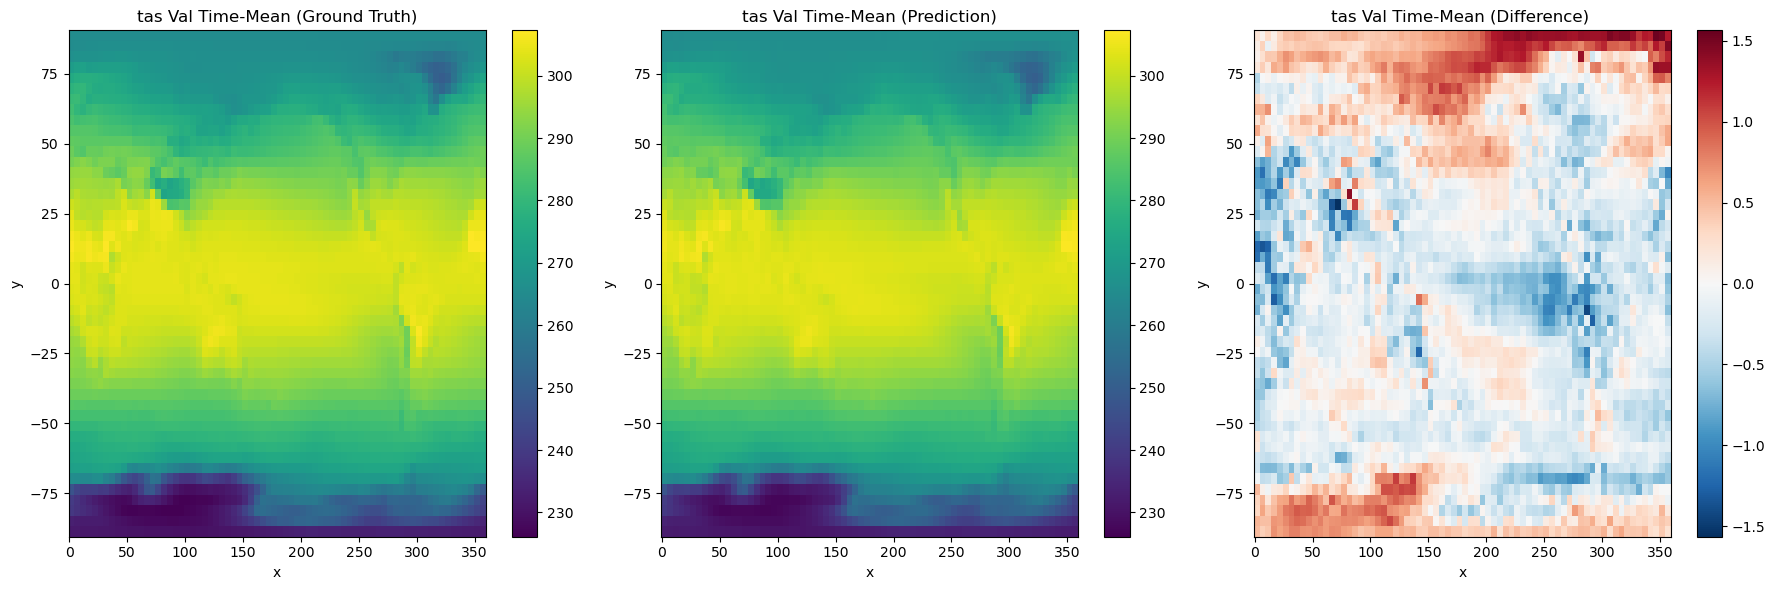

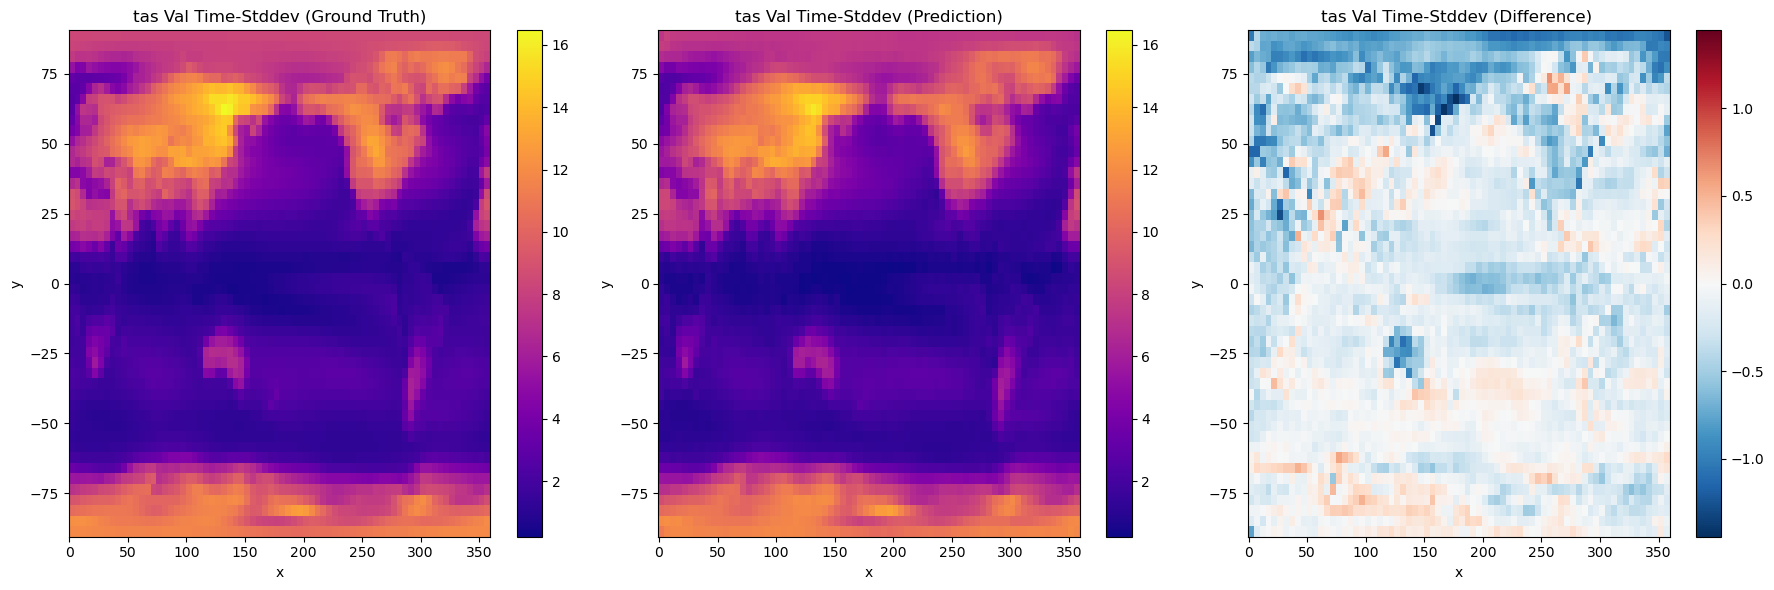

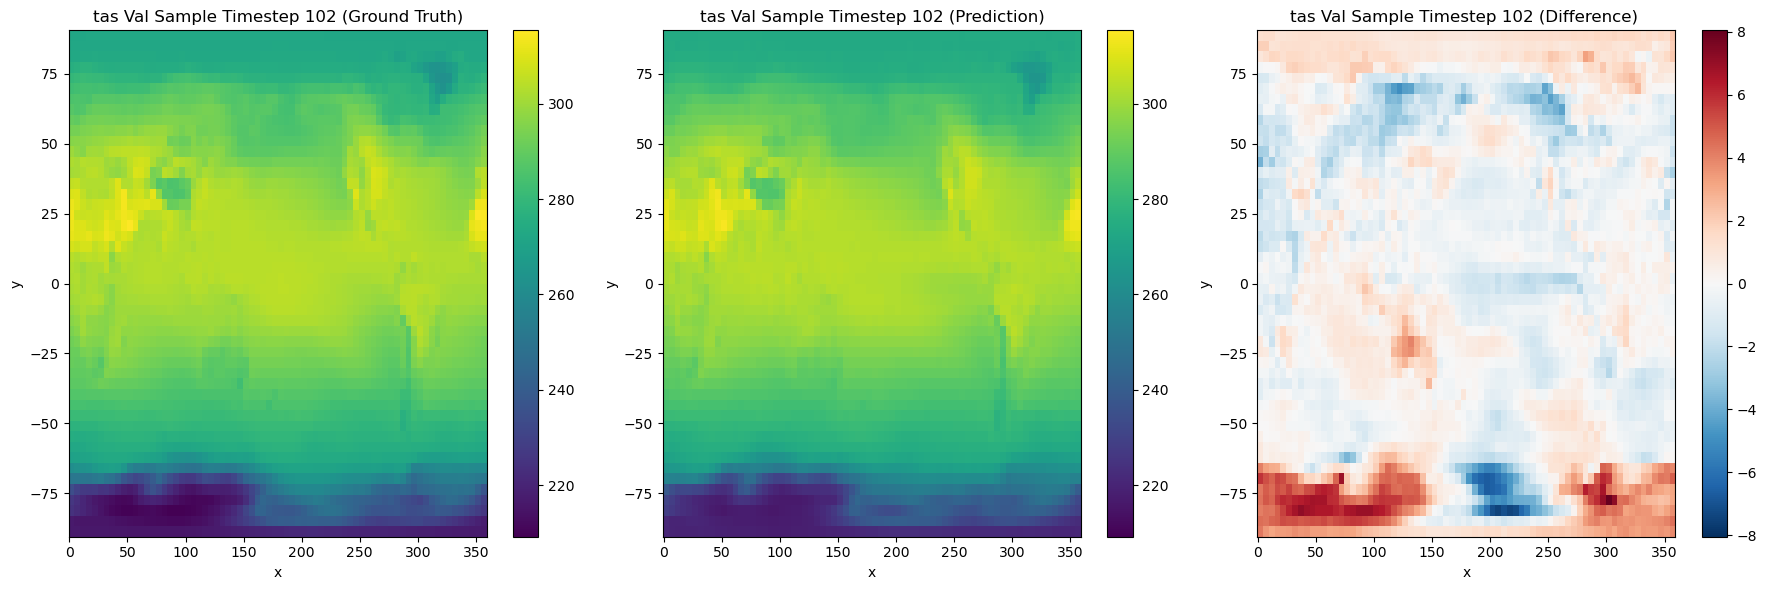

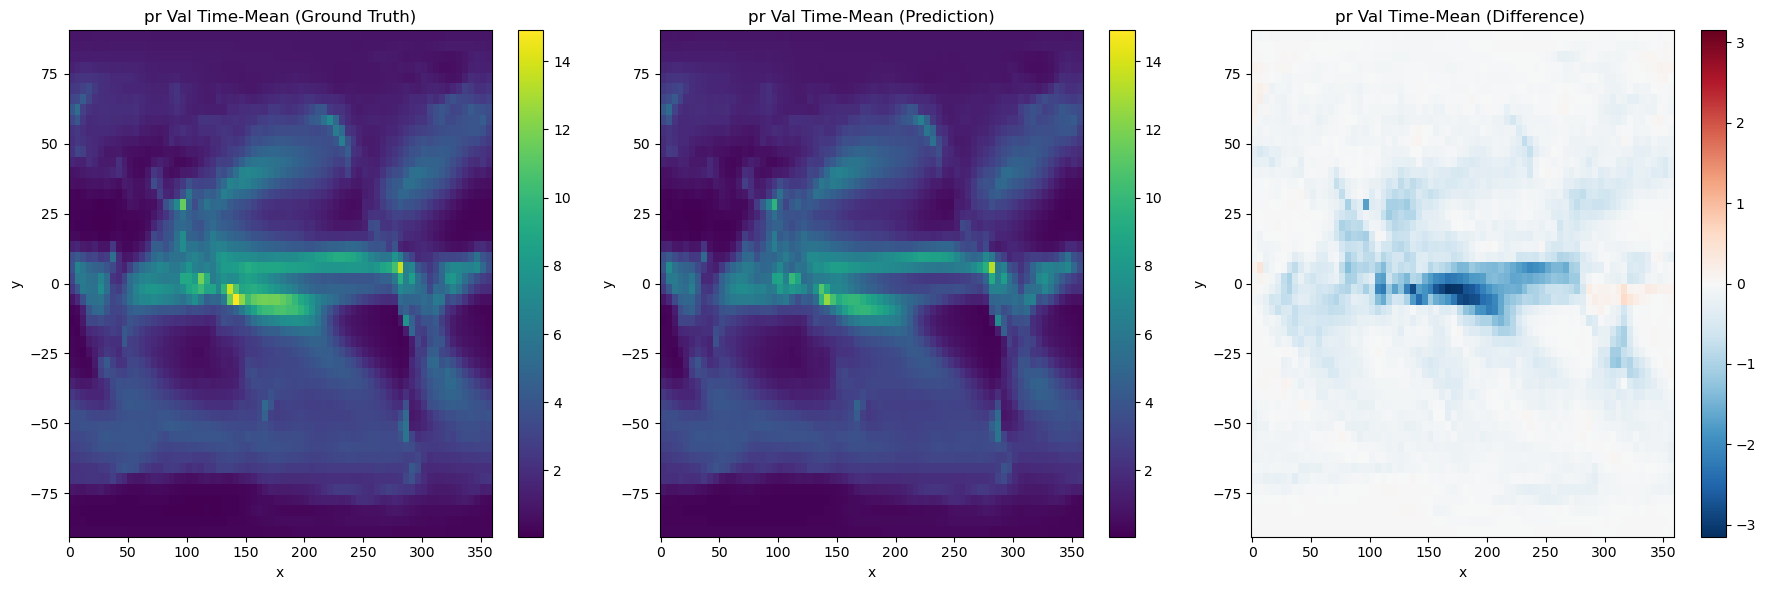

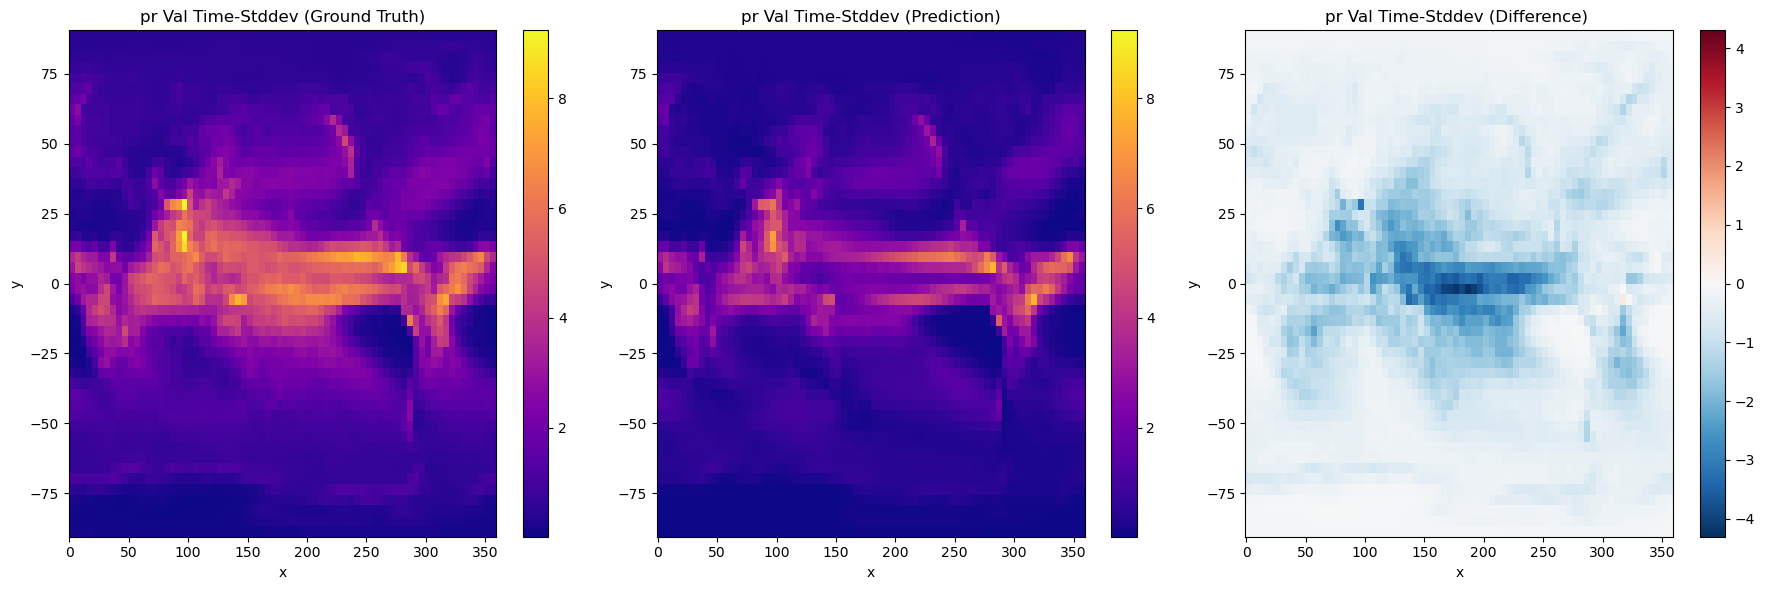

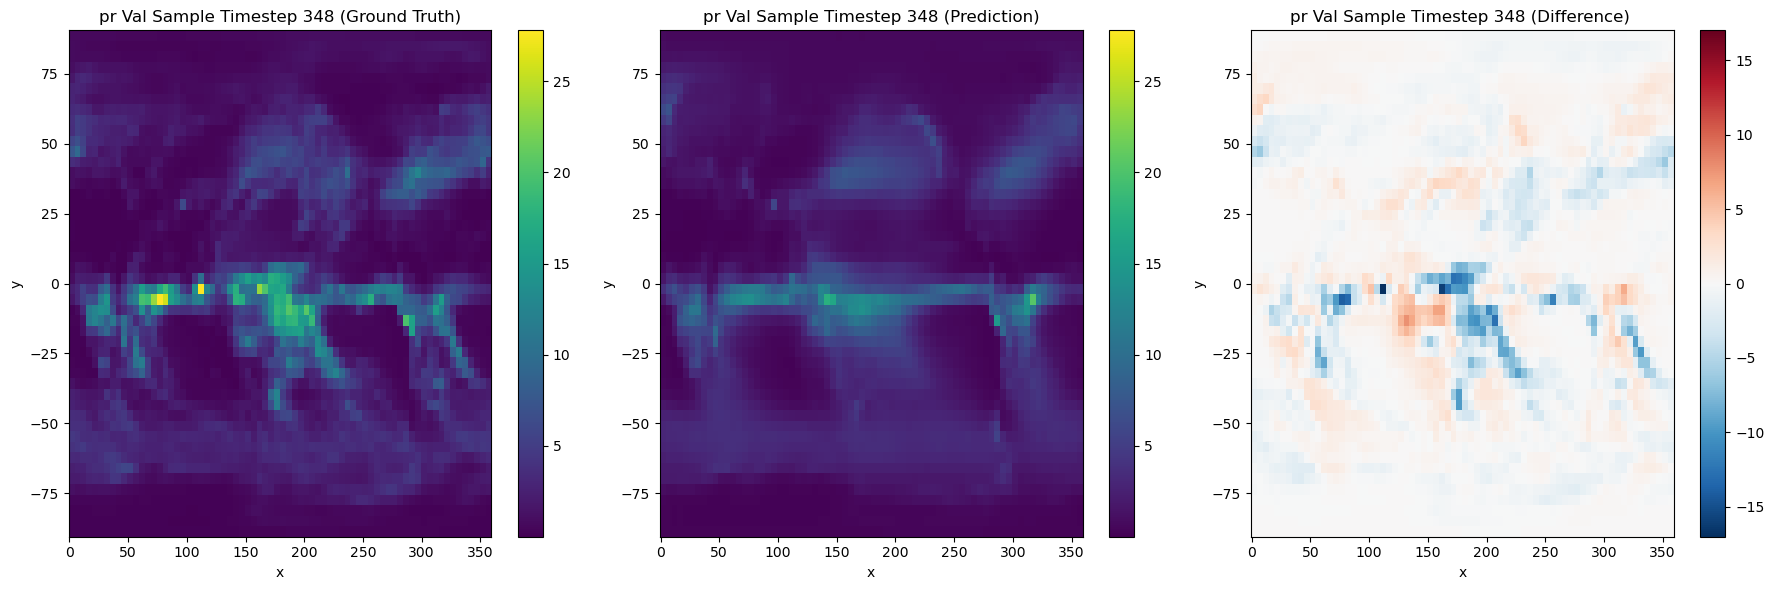

In [43]:
# Load validation predictions
# make sure to have run the validation loop at least once
val_preds = np.load("val_preds.npy")
val_trues = np.load("val_trues.npy")

lat, lon = datamodule.get_coords()
output_vars = datamodule.output_vars
time = np.arange(val_preds.shape[0])

for i, var in enumerate(output_vars):
    pred_xr = xr.DataArray(val_preds[:, i], dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})
    true_xr = xr.DataArray(val_trues[:, i], dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})

    # --- Time Mean ---
    plot_comparison(true_xr.mean("time"), pred_xr.mean("time"), f"{var} Val Time-Mean")

    # --- Time Stddev ---
    plot_comparison(true_xr.std("time"), pred_xr.std("time"), f"{var} Val Time-Stddev", cmap="plasma")

    # --- Random timestep ---
    t_idx = np.random.randint(0, len(time))
    plot_comparison(true_xr.isel(time=t_idx), pred_xr.isel(time=t_idx), f"{var} Val Sample Timestep {t_idx}")


## 🧪 Final Notes

This notebook is meant to serve as a **baseline template** — a starting point to help you get up and running quickly with the climate emulation challenge.

You are **not** required to stick to this exact setup. In fact, we **encourage** you to:

- 🔁 Build on top of the provided `DataModule`. 
- 🧠 Use your own model architectures or training pipelines that you’re more comfortable with 
- ⚗️ Experiment with ideas  
- 🥇 Compete creatively to climb the Kaggle leaderboard  
- 🙌 Most importantly: **have fun** and **learn as much as you can** along the way

This challenge simulates a real-world scientific problem, and there’s no single "correct" approach — so be curious, experiment boldly, and make it your own!


In [24]:
pd.read_csv('submissions/kaggle_submission_20250522_062724.csv')

,ID,Prediction
0,t000_tas_-88.59_1.88,241.996110
1,t000_tas_-88.59_6.88,242.745000
2,t000_tas_-88.59_11.88,242.295100
3,t000_tas_-88.59_16.88,242.389100
4,t000_tas_-88.59_21.88,242.491970
...,...,...
2488315,t359_pr_88.59_336.88,0.777610
2488316,t359_pr_88.59_341.88,0.758484
2488317,t359_pr_88.59_346.88,0.768392
2488318,t359_pr_88.59_351.88,0.753233
